In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-sep-2022/train.csv
/kaggle/input/tabular-playground-series-sep-2022/test.csv


1. The work and approach are referenced from https://www.kaggle.com/code/cabaxiom/tps-sep-22-eda-and-linear-regression-baseline by Cabaxiom.
2. The kernel is used to learn how to apply Linear Regression model to time series analysis
3. It consist of two parts of work: (1) forecast of total sales, (2) production ration forest

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import Ridge


In [3]:
# data input
train_data = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2022/train.csv', parse_dates=['date'])
test_data = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2022/test.csv', parse_dates=['date'])

# Total Sale Forecast

In [4]:
test_data.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [5]:
# aggregate by date
train_data_aggdate = train_data.groupby('date')['num_sold'].sum().reset_index()
test_data_aggdate = test_data.groupby(['date'])['row_id'].sum().reset_index().drop(columns='row_id')

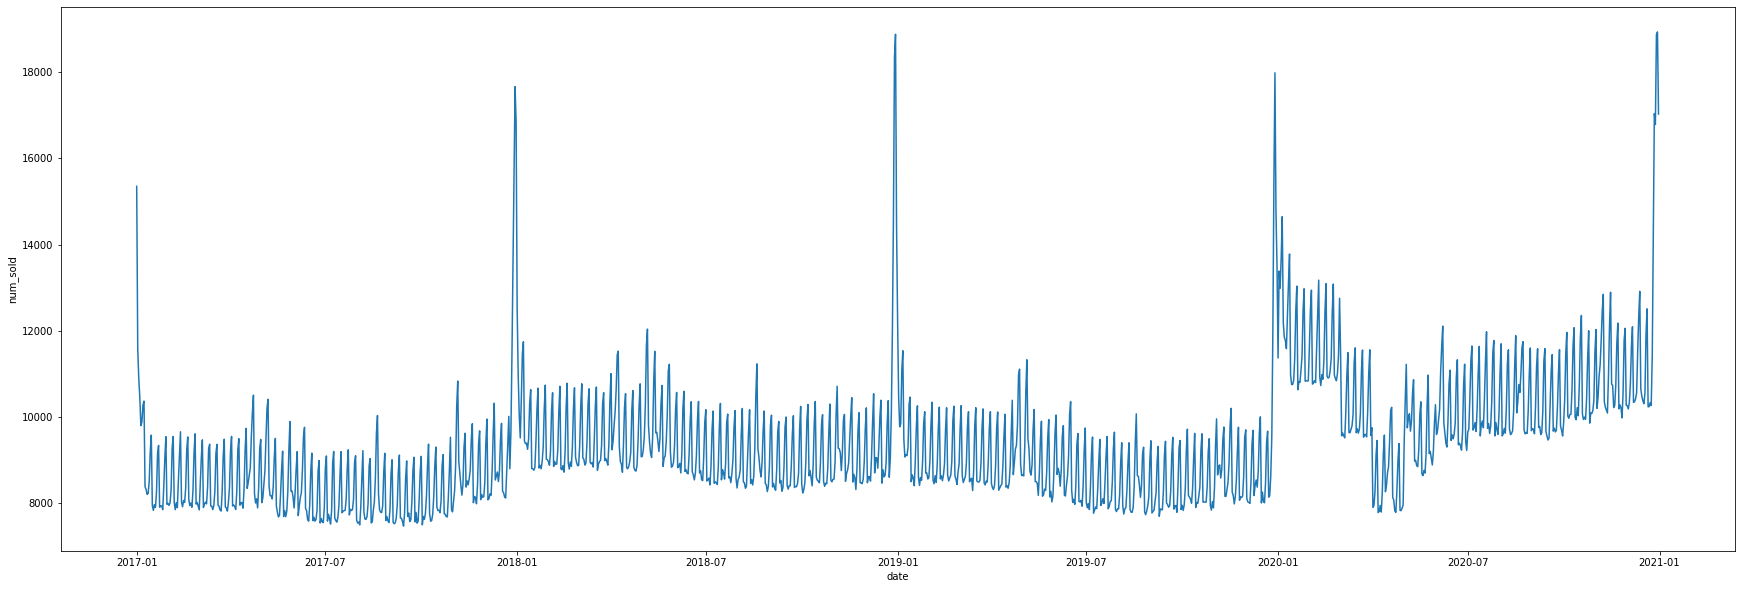

In [6]:
plt.figure(figsize=(30, 10))
sns.lineplot(data=train_data_aggdate, x='date', y='num_sold')
plt.show()

About 2020:
1. The total sum of 2020 is higher than previous years
2. The pandamic period disrupt the several month sales (assuming March to May)

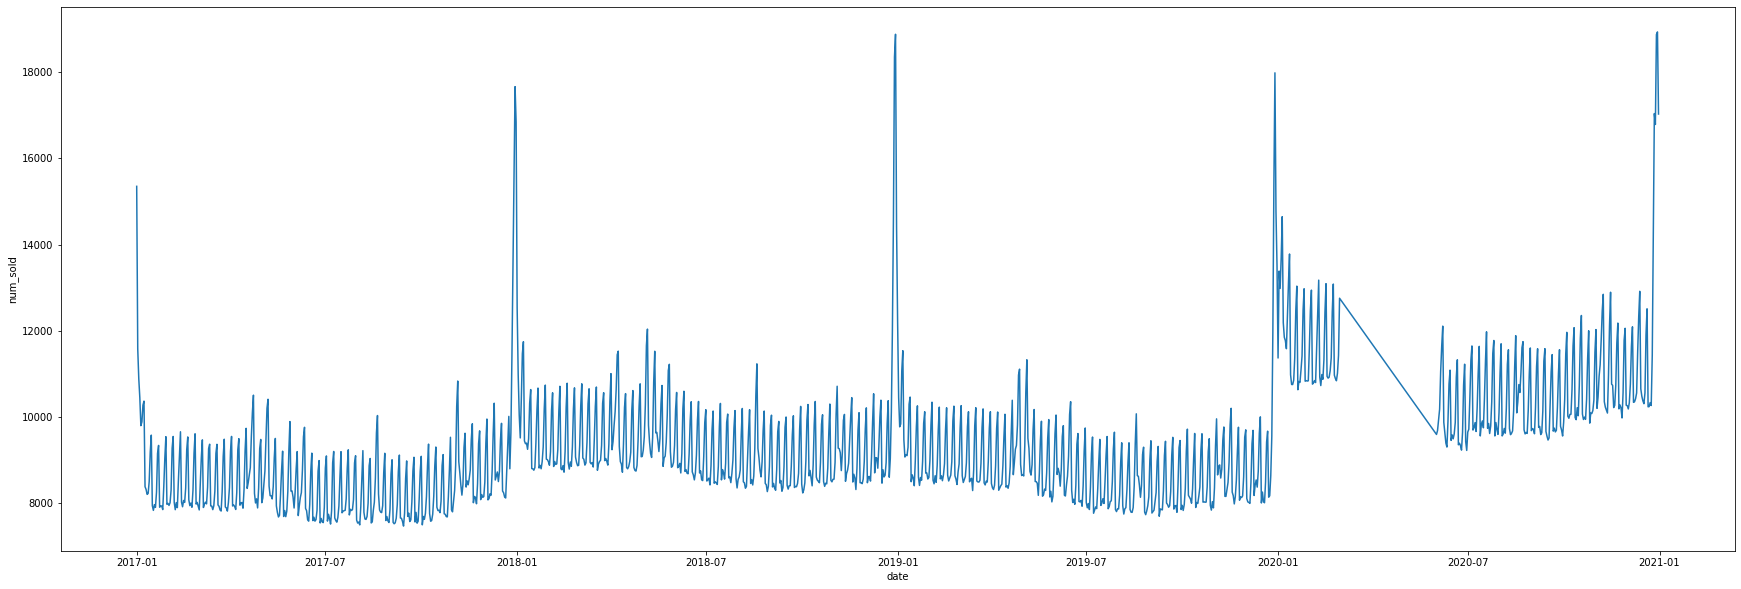

In [7]:
train_data_aggdate_nocovid = train_data_aggdate[ ~((train_data_aggdate['date'] >= "2020-03-01") & (train_data_aggdate['date'] < "2020-06-01"))]
plt.figure(figsize=(30, 10))
sns.lineplot(data=train_data_aggdate_nocovid, x='date', y='num_sold')
plt.show()

In [8]:
def feature_engineer(df):
    new_df = df.copy()
    new_df['month'] = new_df['date'].dt.month
    new_df['month_sin'] = np.sin(new_df['month'] * (2 * np.pi/12))
    new_df['month_cos'] = np.cos(new_df['month'] * (2 * np.pi/12))
    
    new_df['day_of_week'] = df['date'].dt.dayofweek
    new_df['day_of_year'] = df['date'].dt.dayofyear
    
    new_df['year'] = df['date'].dt.year
    
    new_df['important_dates'] = new_df['day_of_year'].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,363,364,365] else 0)
    new_df = new_df.drop(columns=['date', 'month', 'day_of_year'])
    
    new_df = pd.get_dummies(new_df, columns=['important_dates', 'day_of_week'], drop_first=True)
    
    return new_df
    
    

In [9]:
train_data_trans = feature_engineer(train_data_aggdate_nocovid)
test_data_trans = feature_engineer(test_data_aggdate)

In [10]:
test_data_trans.head()

,month_sin,month_cos,year,important_dates_1,important_dates_2,important_dates_3,important_dates_4,important_dates_5,important_dates_6,important_dates_7,...,important_dates_361,important_dates_363,important_dates_364,important_dates_365,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,0.5,0.866025,2021,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.5,0.866025,2021,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.5,0.866025,2021,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.5,0.866025,2021,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.5,0.866025,2021,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [11]:
X_train = train_data_trans.drop(columns='num_sold')
y_train = train_data_trans['num_sold']
X_test = test_data_trans

In [12]:
# keep the test dates
test_data_pred = test_data.groupby(['date']).first().reset_index()[['date']]

Define and train the model

In [13]:
model = Ridge(tol=1e-2, max_iter=1000000, random_state=0)
model.fit(X_train, y_train)

Ridge(max_iter=1000000, random_state=0, tol=0.01)

In [14]:
pred = model.predict(X_test)

In [15]:
test_data_pred['num_sold'] = pred

In [16]:
full_data = pd.concat([train_data_aggdate, test_data_pred]).reset_index(drop=True)

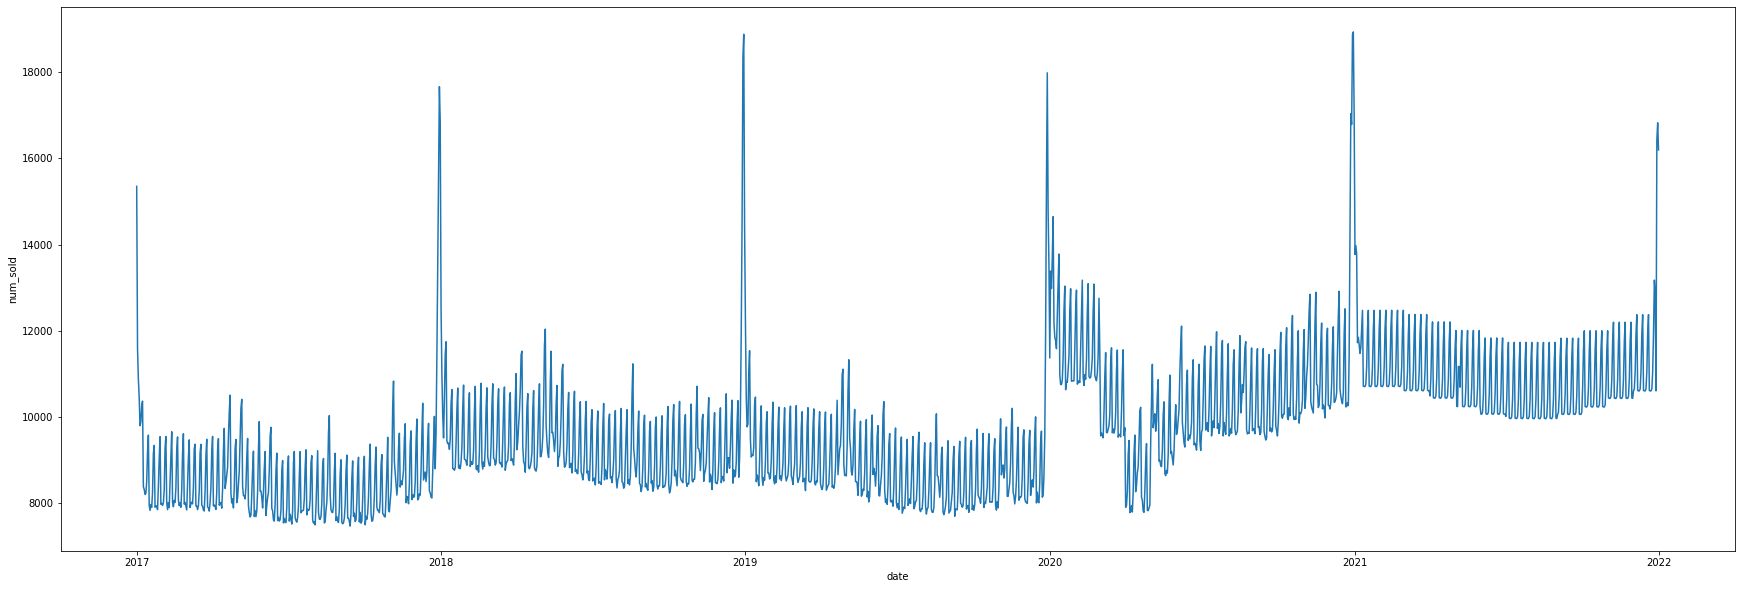

In [17]:
plt.figure(figsize=(30, 10))
sns.lineplot(data=full_data, x='date', y='num_sold')
plt.show()

# Production Ratio Forest

In [18]:
products = ['Kaggle Advanced Techniques', 'Kaggle Getting Started', 'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose']

In [19]:
train_data_product_daily = train_data.groupby(['date', 'product']).sum().reset_index()
train_data_product_daily

,date,product,row_id,num_sold
0,2017-01-01,Kaggle Advanced Techniques,264,4267
1,2017-01-01,Kaggle Getting Started,276,3492
2,2017-01-01,Kaggle Recipe Book,288,2900
3,2017-01-01,Kaggle for Kids: One Smart Goose,300,4693
4,2017-01-02,Kaggle Advanced Techniques,840,3242
...,...,...,...,...
5839,2020-12-30,Kaggle for Kids: One Smart Goose,840684,5699
5840,2020-12-31,Kaggle Advanced Techniques,841224,4968
5841,2020-12-31,Kaggle Getting Started,841236,3780
5842,2020-12-31,Kaggle Recipe Book,841248,3301


In [20]:
train_data_product_pivot_daily = train_data_product_daily.pivot_table(index='date', columns='product', values='num_sold')

train_data_product_pivot_daily['total'] = train_data_product_pivot_daily.sum(axis=1)

for product in products:
    train_data_product_pivot_daily[product] = train_data_product_pivot_daily[product]/train_data_product_pivot_daily['total']
    
train_data_product_percentage_daily = train_data_product_pivot_daily.reset_index().drop(columns=['total'])

train_data_product_percentage_daily = train_data_product_percentage_daily.melt(id_vars=['date']).rename(columns={'value':'num_sold'})
train_data_product_percentage_daily

,date,product,num_sold
0,2017-01-01,Kaggle Advanced Techniques,0.277944
1,2017-01-02,Kaggle Advanced Techniques,0.280014
2,2017-01-03,Kaggle Advanced Techniques,0.291529
3,2017-01-04,Kaggle Advanced Techniques,0.282240
4,2017-01-05,Kaggle Advanced Techniques,0.283104
...,...,...,...
5839,2020-12-27,Kaggle for Kids: One Smart Goose,0.306537
5840,2020-12-28,Kaggle for Kids: One Smart Goose,0.306332
5841,2020-12-29,Kaggle for Kids: One Smart Goose,0.308699
5842,2020-12-30,Kaggle for Kids: One Smart Goose,0.300929


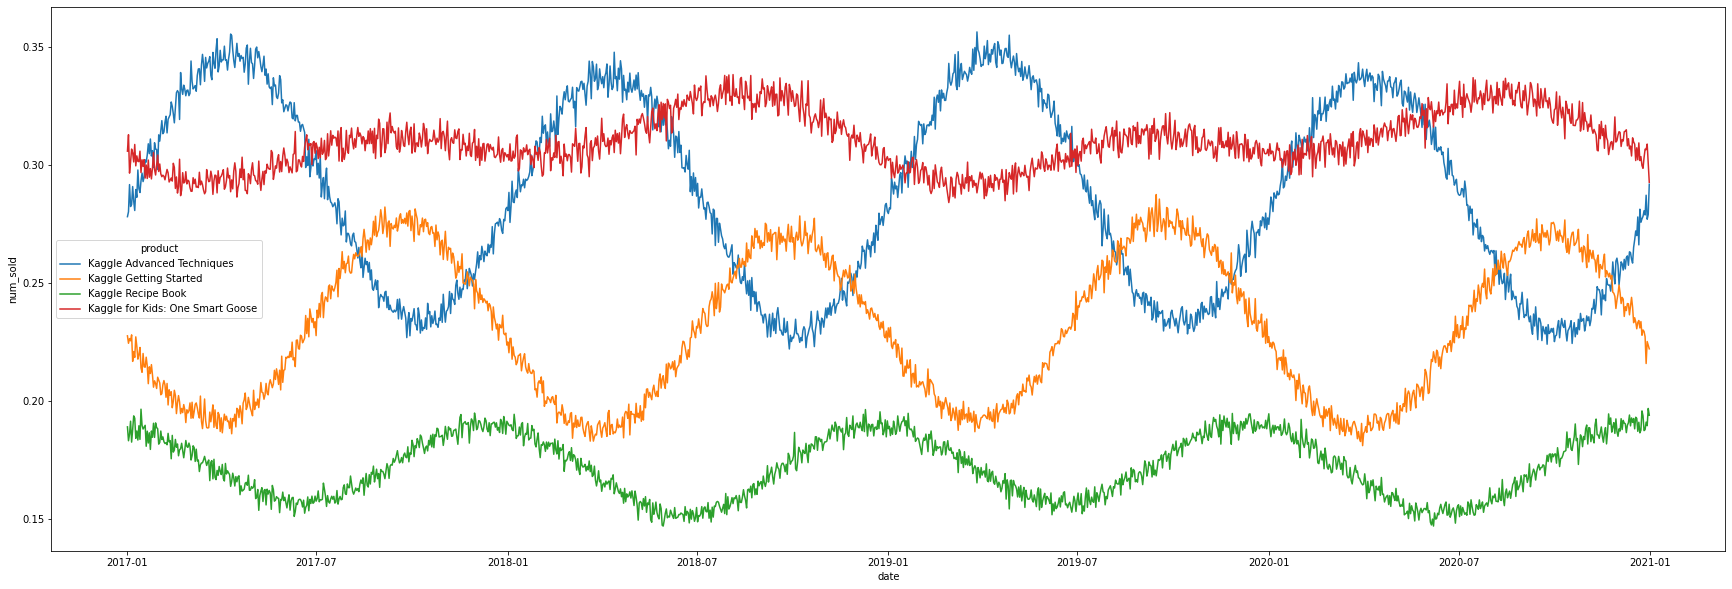

In [21]:
plt.figure(figsize=(30,10))
sns.lineplot(data=train_data_product_percentage_daily, x='date', y='num_sold', hue='product')
plt.show()

In [22]:
train_data_product_percentage_daily

,date,product,num_sold
0,2017-01-01,Kaggle Advanced Techniques,0.277944
1,2017-01-02,Kaggle Advanced Techniques,0.280014
2,2017-01-03,Kaggle Advanced Techniques,0.291529
3,2017-01-04,Kaggle Advanced Techniques,0.282240
4,2017-01-05,Kaggle Advanced Techniques,0.283104
...,...,...,...
5839,2020-12-27,Kaggle for Kids: One Smart Goose,0.306537
5840,2020-12-28,Kaggle for Kids: One Smart Goose,0.306332
5841,2020-12-29,Kaggle for Kids: One Smart Goose,0.308699
5842,2020-12-30,Kaggle for Kids: One Smart Goose,0.300929


In [23]:
 test_data_product_percentage_daily_temp = train_data_product_percentage_daily[(train_data_product_percentage_daily['date']< '2020-01-01') & (train_data_product_percentage_daily['date'] >= '2019-01-01')].reset_index(drop=True).rename(columns={'num_sold':'product_percentage_daily'})

In [24]:
test_data_product_percentage_daily_temp

,date,product,product_percentage_daily
0,2019-01-01,Kaggle Advanced Techniques,0.279273
1,2019-01-02,Kaggle Advanced Techniques,0.281654
2,2019-01-03,Kaggle Advanced Techniques,0.281224
3,2019-01-04,Kaggle Advanced Techniques,0.294154
4,2019-01-05,Kaggle Advanced Techniques,0.291215
...,...,...,...
1455,2019-12-27,Kaggle for Kids: One Smart Goose,0.306554
1456,2019-12-28,Kaggle for Kids: One Smart Goose,0.304763
1457,2019-12-29,Kaggle for Kids: One Smart Goose,0.304536
1458,2019-12-30,Kaggle for Kids: One Smart Goose,0.304807


In [25]:
test_data_product_percentage_daily_temp

,date,product,product_percentage_daily
0,2019-01-01,Kaggle Advanced Techniques,0.279273
1,2019-01-02,Kaggle Advanced Techniques,0.281654
2,2019-01-03,Kaggle Advanced Techniques,0.281224
3,2019-01-04,Kaggle Advanced Techniques,0.294154
4,2019-01-05,Kaggle Advanced Techniques,0.291215
...,...,...,...
1455,2019-12-27,Kaggle for Kids: One Smart Goose,0.306554
1456,2019-12-28,Kaggle for Kids: One Smart Goose,0.304763
1457,2019-12-29,Kaggle for Kids: One Smart Goose,0.304536
1458,2019-12-30,Kaggle for Kids: One Smart Goose,0.304807


In [26]:
test_data_date_temp = pd.concat([test_data_aggdate, test_data_aggdate, test_data_aggdate, test_data_aggdate]).reset_index(drop=True)

In [27]:
product_percentage_daily = pd.merge(test_data_product_percentage_daily_temp,test_data_date_temp, left_index=True, right_index=True).drop(columns='date_x').rename(columns={'date_y': 'date'})

In [28]:
product_percentage_daily

,product,product_percentage_daily,date
0,Kaggle Advanced Techniques,0.279273,2021-01-01
1,Kaggle Advanced Techniques,0.281654,2021-01-02
2,Kaggle Advanced Techniques,0.281224,2021-01-03
3,Kaggle Advanced Techniques,0.294154,2021-01-04
4,Kaggle Advanced Techniques,0.291215,2021-01-05
...,...,...,...
1455,Kaggle for Kids: One Smart Goose,0.306554,2021-12-27
1456,Kaggle for Kids: One Smart Goose,0.304763,2021-12-28
1457,Kaggle for Kids: One Smart Goose,0.304536,2021-12-29
1458,Kaggle for Kids: One Smart Goose,0.304807,2021-12-30


## Store Percentage

In [29]:
store_percentage = (train_data.groupby(['store'])['num_sold'].sum()/train_data.groupby(['store'])['num_sold'].sum().sum()).reset_index().rename(columns={'num_sold': 'store_percentage'})
store_percentage


,store,store_percentage
0,KaggleMart,0.742515
1,KaggleRama,0.257485


## Country Percentage

In [30]:
country_percentage = (train_data.groupby(['country'])['num_sold'].sum()/train_data.groupby(['country'])['num_sold'].sum().sum()).reset_index().rename(columns={'num_sold': 'country_percentage'})
country_percentage

,country,country_percentage
0,Belgium,0.204104
1,France,0.184381
2,Germany,0.204498
3,Italy,0.161540
4,Poland,0.098457
5,Spain,0.147020


In [31]:
temp1 = pd.merge(test_data, test_data_pred, on='date')

In [32]:
temp1

,row_id,date,country,store,product,num_sold
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,13770.626832
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,13770.626832
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,13770.626832
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,13770.626832
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,13770.626832
...,...,...,...,...,...,...
17515,87643,2021-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,16197.967287
17516,87644,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,16197.967287
17517,87645,2021-12-31,Spain,KaggleRama,Kaggle Getting Started,16197.967287
17518,87646,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book,16197.967287


In [33]:
temp2 = pd.merge(temp1, country_percentage, on='country')

In [34]:
temp2

,row_id,date,country,store,product,num_sold,country_percentage
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,13770.626832,0.204104
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,13770.626832,0.204104
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,13770.626832,0.204104
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,13770.626832,0.204104
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,13770.626832,0.204104
...,...,...,...,...,...,...,...
17515,87643,2021-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,16197.967287,0.147020
17516,87644,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,16197.967287,0.147020
17517,87645,2021-12-31,Spain,KaggleRama,Kaggle Getting Started,16197.967287,0.147020
17518,87646,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book,16197.967287,0.147020


In [35]:
temp3 = pd.merge(temp2, store_percentage, on='store')

In [36]:
temp3

,row_id,date,country,store,product,num_sold,country_percentage,store_percentage
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,13770.626832,0.204104,0.742515
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,13770.626832,0.204104,0.742515
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,13770.626832,0.204104,0.742515
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,13770.626832,0.204104,0.742515
4,70176,2021-01-02,Belgium,KaggleMart,Kaggle Advanced Techniques,13977.579885,0.204104,0.742515
...,...,...,...,...,...,...,...,...
17515,87599,2021-12-30,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,16826.690562,0.147020,0.257485
17516,87644,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,16197.967287,0.147020,0.257485
17517,87645,2021-12-31,Spain,KaggleRama,Kaggle Getting Started,16197.967287,0.147020,0.257485
17518,87646,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book,16197.967287,0.147020,0.257485


In [37]:
product_percentage_daily

,product,product_percentage_daily,date
0,Kaggle Advanced Techniques,0.279273,2021-01-01
1,Kaggle Advanced Techniques,0.281654,2021-01-02
2,Kaggle Advanced Techniques,0.281224,2021-01-03
3,Kaggle Advanced Techniques,0.294154,2021-01-04
4,Kaggle Advanced Techniques,0.291215,2021-01-05
...,...,...,...
1455,Kaggle for Kids: One Smart Goose,0.306554,2021-12-27
1456,Kaggle for Kids: One Smart Goose,0.304763,2021-12-28
1457,Kaggle for Kids: One Smart Goose,0.304536,2021-12-29
1458,Kaggle for Kids: One Smart Goose,0.304807,2021-12-30


In [38]:
temp4 = pd.merge(temp3, product_percentage_daily, on=['product', 'date'], how='left')

In [39]:
temp4

,row_id,date,country,store,product,num_sold,country_percentage,store_percentage,product_percentage_daily
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,13770.626832,0.204104,0.742515,0.279273
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,13770.626832,0.204104,0.742515,0.230832
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,13770.626832,0.204104,0.742515,0.188119
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,13770.626832,0.204104,0.742515,0.301776
4,70176,2021-01-02,Belgium,KaggleMart,Kaggle Advanced Techniques,13977.579885,0.204104,0.742515,0.281654
...,...,...,...,...,...,...,...,...,...
17515,87599,2021-12-30,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,16826.690562,0.147020,0.257485,0.304807
17516,87644,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,16197.967287,0.147020,0.257485,0.277440
17517,87645,2021-12-31,Spain,KaggleRama,Kaggle Getting Started,16197.967287,0.147020,0.257485,0.224633
17518,87646,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book,16197.967287,0.147020,0.257485,0.191453


In [40]:
temp4['output'] = temp4['num_sold'] * temp4['country_percentage'] * temp4['store_percentage'] * temp4['product_percentage_daily']

In [41]:
temp4

,row_id,date,country,store,product,num_sold,country_percentage,store_percentage,product_percentage_daily,output
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,13770.626832,0.204104,0.742515,0.279273,582.827013
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,13770.626832,0.204104,0.742515,0.230832,481.733080
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,13770.626832,0.204104,0.742515,0.188119,392.592822
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,13770.626832,0.204104,0.742515,0.301776,629.787877
4,70176,2021-01-02,Belgium,KaggleMart,Kaggle Advanced Techniques,13977.579885,0.204104,0.742515,0.281654,596.628417
...,...,...,...,...,...,...,...,...,...,...
17515,87599,2021-12-30,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,16826.690562,0.147020,0.257485,0.304807,194.156057
17516,87644,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,16197.967287,0.147020,0.257485,0.277440,170.120804
17517,87645,2021-12-31,Spain,KaggleRama,Kaggle Getting Started,16197.967287,0.147020,0.257485,0.224633,137.740629
17518,87646,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book,16197.967287,0.147020,0.257485,0.191453,117.395162


In [42]:
submission = pd.read_csv("../input/tabular-playground-series-sep-2022/sample_submission.csv")
submission['num_sold'] = temp4['num_sold']

In [43]:
submission.to_csv('submission.csv', index=False)